# Pseudo Double Source Plane Lenses (PDSPL) Forecast
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from tqdm import tqdm
import corner

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# from hierarc.Likelihood.LensLikelihood.double_source_plane import (
#     beta_double_source_plane,
#     # beta2theta_e_ratio,
# )

from astropy.table import Table

In [2]:
# Load the pairing parameters table
loaded_pairing_parameters_table = Table.read(
    "pairing_parameters_table_6Mil.fits",
    format="fits",
)

# get the differences in deflector magnitudes, sizes as well as a column in the table
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_i"] - loaded_pairing_parameters_table["mag_D2_i"],
    name="delta_mag_i_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_r"] - loaded_pairing_parameters_table["mag_D2_r"],
    name="delta_mag_r_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_g"] - loaded_pairing_parameters_table["mag_D2_g"],
    name="delta_mag_g_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_z"] - loaded_pairing_parameters_table["mag_D2_z"],
    name="delta_mag_z_D",
)
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["mag_D1_y"] - loaded_pairing_parameters_table["mag_D2_y"],
    name="delta_mag_y_D",
)

# get the differences in source size as well as a column in the table
loaded_pairing_parameters_table.add_column(
    loaded_pairing_parameters_table["size_D1"] - loaded_pairing_parameters_table["size_D2"],
    name="delta_size_D",
)

# absolute differences in deflector magnitudes, sizes as well as a column in the table
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_i"] - loaded_pairing_parameters_table["mag_D2_i"]),
    name="abs_delta_mag_i_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_r"] - loaded_pairing_parameters_table["mag_D2_r"]),
    name="abs_delta_mag_r_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_g"] - loaded_pairing_parameters_table["mag_D2_g"]),
    name="abs_delta_mag_g_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_z"] - loaded_pairing_parameters_table["mag_D2_z"]),
    name="abs_delta_mag_z_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["mag_D1_y"] - loaded_pairing_parameters_table["mag_D2_y"]),
    name="abs_delta_mag_y_D",
)
loaded_pairing_parameters_table.add_column(
    np.abs(loaded_pairing_parameters_table["size_D1"] - loaded_pairing_parameters_table["size_D2"]),
    name="abs_delta_size_D",
)


# add the absolute differences in beta to the pairing_parameters table
abs_diff_theta_E_1 = np.abs(
    loaded_pairing_parameters_table["theta_E_ratio"] - loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
)
abs_diff_theta_E_2 = np.abs(
    loaded_pairing_parameters_table["theta_E_ratio"] - loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"]
)

loaded_pairing_parameters_table.add_column(
    abs_diff_theta_E_1,
    name="abs_diff_theta_E_1",
)
loaded_pairing_parameters_table.add_column(
    abs_diff_theta_E_2,
    name="abs_diff_theta_E_2",
)



# remove infs and nans in theta_E_ratio and theta_E1_by_theta_E2_virtual and theta_E1_virtual_by_theta_E2
mask = np.isfinite(loaded_pairing_parameters_table["theta_E_ratio"]) & np.isfinite(
    loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
) & np.isfinite(loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"])
mask &= ~np.isnan(loaded_pairing_parameters_table["theta_E_ratio"]) & ~np.isnan(
    loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
) & ~np.isnan(loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"])
mask &= loaded_pairing_parameters_table["theta_E_ratio"] > 0
mask &= loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"] > 0
mask &= loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"] > 0
mask &= loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"] < 1e3
mask &= loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"] < 1e3

loaded_pairing_parameters_table = loaded_pairing_parameters_table[mask]

# make the dict from the table
pairing_parameters = dict(loaded_pairing_parameters_table)

# print the table
loaded_pairing_parameters_table

z_D1,z_D2,z_S1,z_S2,theta_E1,theta_E2,theta_E_ratio,theta_E1_virtual,theta_E2_virtual,theta_E1_by_theta_E2_virtual,theta_E1_virtual_by_theta_E2,sigma_v_D1,sigma_v_D2,beta_DSPL_D1,beta_DSPL_D2,delta_z_D,delta_sigma_v_D,abs_delta_z_D,abs_delta_sigma_v_D,mag_S1_i,mag_S2_i,mag_S1_r,mag_S2_r,mag_S1_g,mag_S2_g,mag_S1_z,mag_S2_z,mag_S1_y,mag_S2_y,mag_D1_i,mag_D2_i,mag_D1_r,mag_D2_r,mag_D1_g,mag_D2_g,mag_D1_z,mag_D2_z,mag_D1_y,mag_D2_y,size_D1,size_D2,delta_mag_i_D,delta_mag_r_D,delta_mag_g_D,delta_mag_z_D,delta_mag_y_D,delta_size_D,abs_delta_mag_i_D,abs_delta_mag_r_D,abs_delta_mag_g_D,abs_delta_mag_z_D,abs_delta_mag_y_D,abs_delta_size_D,abs_diff_theta_E_1,abs_diff_theta_E_2
,,,,arcsec,arcsec,,arcsec,arcsec,,,km / s,km / s,,,,km / s,,km / s,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,rad,rad,mag,mag,mag,mag,mag,rad,mag,mag,mag,mag,mag,rad,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.3820624417152292,2.108541578155249,2.6434964327981225,3.8369728740815106,0.15948790748146047,0.2767404924332489,0.5763085339595893,0.12435778071831056,0.21694321805813543,0.7351596832988881,0.4493660455139439,130.62627829399077,198.2789915889441,0.7475577100359314,0.4493660455139439,-0.7264791364400196,-67.65271329495334,0.7264791364400196,67.65271329495334,26.511171315418938,26.985589869890063,26.700172344893392,26.979375347809302,26.8106211835907,27.552072637961402,26.509064729661343,26.88240048025944,26.387761932214968,26.852842834341878,23.442563846098864,22.84616353326623,23.732827859126886,23.05666118977274,23.84783743349289,23.354000132342634,23.168948960877515,22.53553252914117,22.685583951294646,22.331071153594493,0.45904889216655315,1.172952448578423,0.5964003128326354,0.6761666693541457,0.4938373011502577,0.6334164317363431,0.35451279770015276,-0.7139035564118699,0.5964003128326354,0.6761666693541457,0.4938373011502577,0.6334164317363431,0.35451279770015276,0.7139035564118699,0.1588511493392989,0.12694248844564537
1.3820624417152292,0.8677986834088184,2.6434964327981225,1.5842741767829696,0.15948790748146047,0.5473299961974719,0.29139259421096775,0.7992255666158121,0.041570111204880085,3.8366004530374584,1.4602261381038186,130.62627829399077,237.52304191527455,3.70381006561787,1.4724290395171675,0.5142637583064108,-106.89676362128378,0.5142637583064108,106.89676362128378,26.511171315418938,26.591232211109276,26.700172344893392,27.133048957084146,26.8106211835907,27.497325877748136,26.509064729661343,26.248882125274672,26.387761932214968,25.83188405289629,23.442563846098864,20.642862514405305,23.732827859126886,21.479693852757467,23.84783743349289,22.218468730723405,23.168948960877515,20.142065748321148,22.685583951294646,19.951139695234478,0.45904889216655315,1.341260604853299,2.7997013316935586,2.253134006369418,1.6293687027694865,3.026883212556367,2.7344442560601685,-0.8822117126867457,2.7997013316935586,2.253134006369418,1.6293687027694865,3.026883212556367,2.7344442560601685,0.8822117126867457,3.545207858826491,1.168833543892851
1.3820624417152292,0.6418069536959404,2.6434964327981225,2.35255544079326,0.15948790748146047,0.20342043710214563,0.7840308955848676,0.211225678057299,0.13718430827714115,1.1625812710245356,1.0383699940199913,130.62627829399077,111.5776410767352,1.154970318998,1.039810213988341,0.7402554880192888,19.04863721725556,0.7402554880192888,19.04863721725556,26.511171315418938,27.240045614261163,26.700172344893392,27.40300822330707,26.8106211835907,27.637546852020975,26.509064729661343,27.10558958537655,26.387761932214968,26.85188493603458,23.442563846098864,21.51113061479346,23.732827859126886,21.

In [3]:
pairing_parameters = dict(loaded_pairing_parameters_table)
# for each key in the dictionary, convert the value to a numpy array
for key in pairing_parameters.keys():
    pairing_parameters[key] = np.array(pairing_parameters[key])

Total number of pairs: 1020


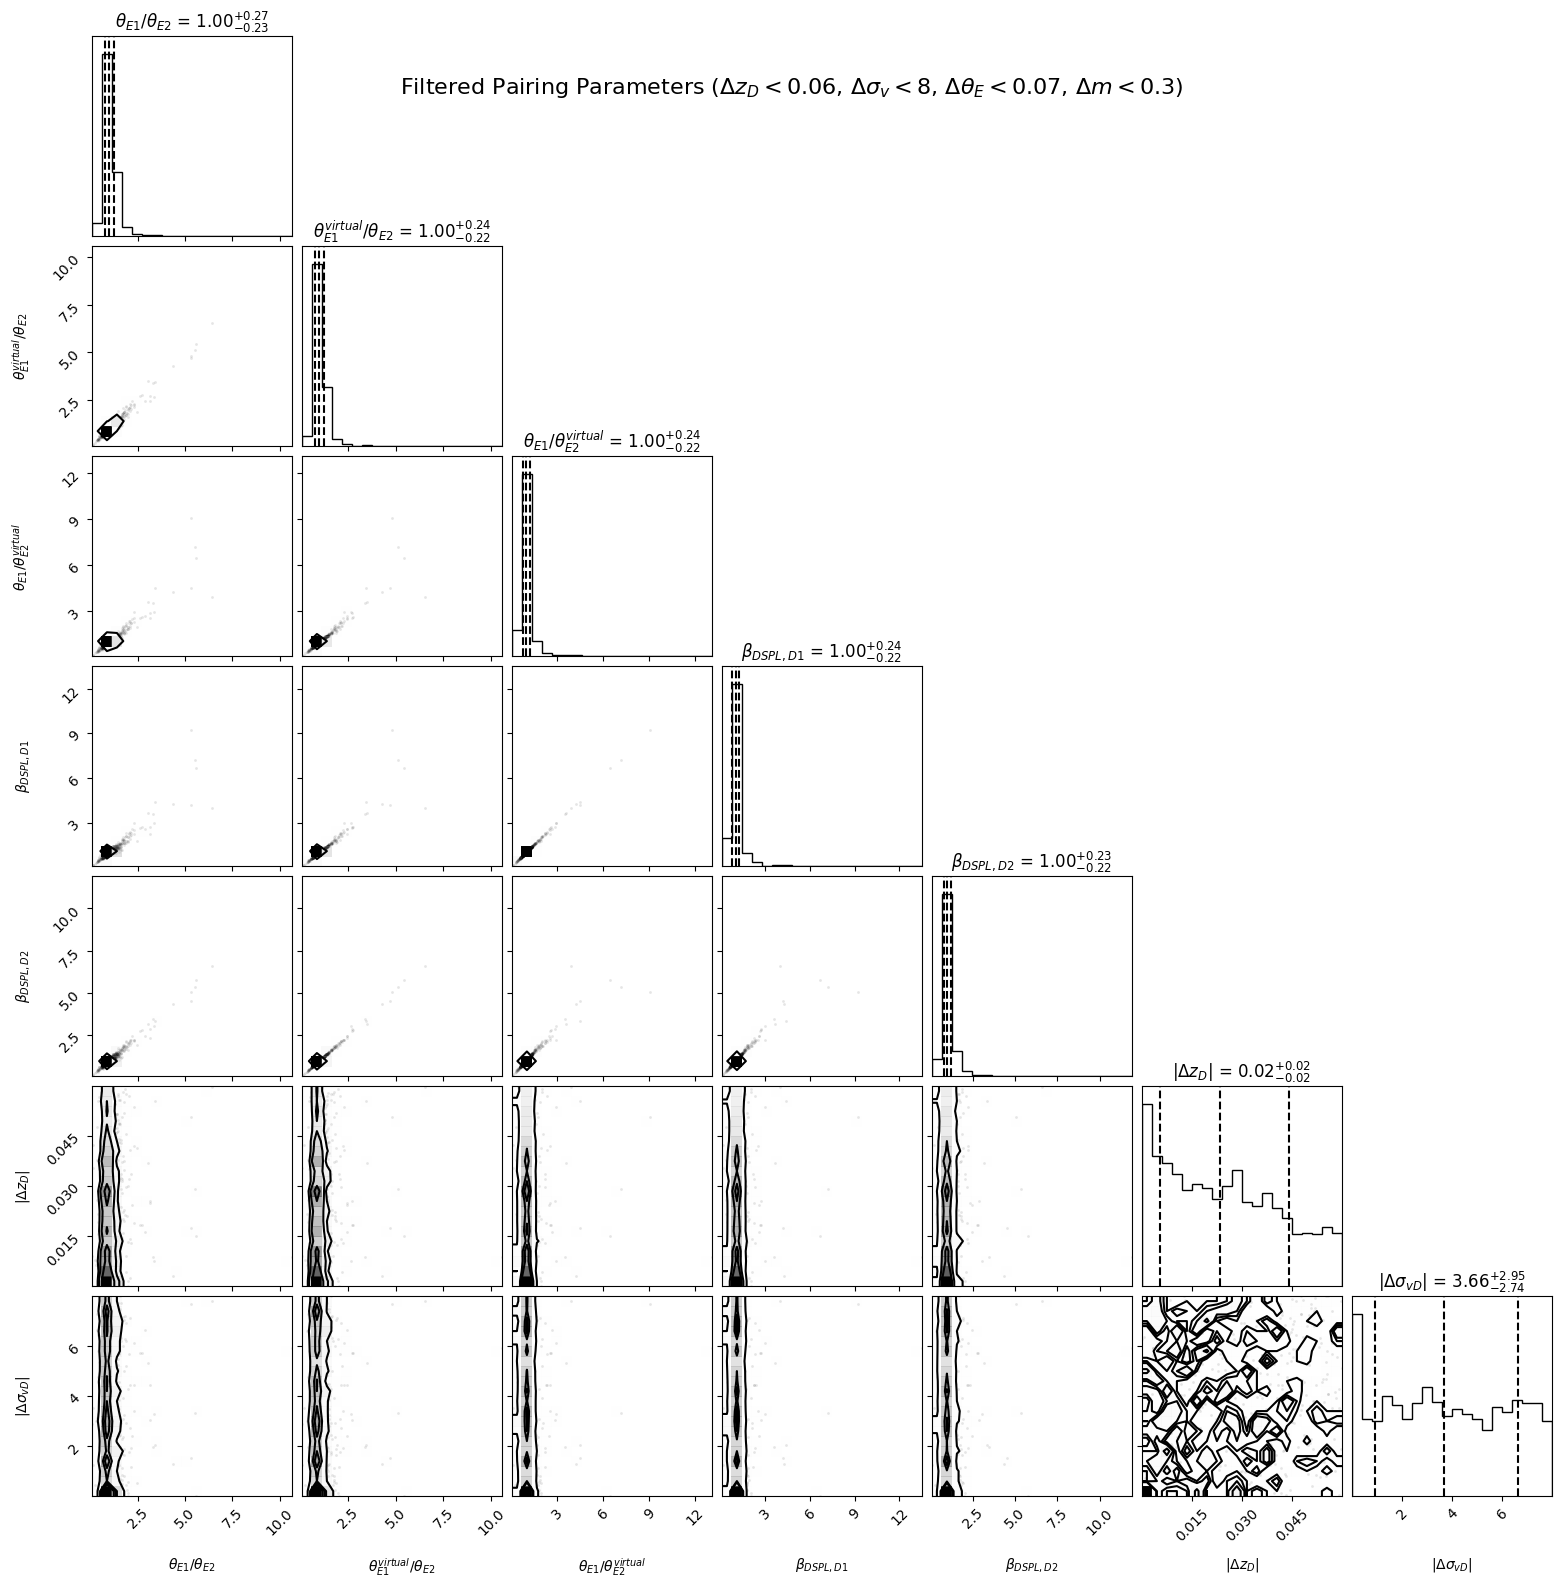

In [4]:
# limit the pairs to those with small delta_z_D and delta_sigma_v_D
# Therefore the approximate maximum values for the parameters are:
threshold_abs_delta_z_D = 0.06
threshold_abs_delta_sigma_v_D = 8 # km/s
threshold_abs_delta_size_D = 0.07 # rad
threshold_abs_delta_mag_X_D = 0.3 # mag


# plot the theta_E_ratio, theta_E1_by_theta_E2_virtual, theta_E1_virtual_by_theta_E2 after the mask with above values
mask = (
    (pairing_parameters["abs_delta_z_D"] < threshold_abs_delta_z_D)
    & (pairing_parameters["abs_delta_sigma_v_D"] < threshold_abs_delta_sigma_v_D)
    & (pairing_parameters["abs_delta_size_D"] < threshold_abs_delta_size_D)
    & (pairing_parameters["abs_delta_mag_i_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_r_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_g_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_z_D"] < threshold_abs_delta_mag_X_D)
    & (pairing_parameters["abs_delta_mag_y_D"] < threshold_abs_delta_mag_X_D)
)

filtered_pairing_parameters = {
    key: pairing_parameters[key][mask]
    for key in pairing_parameters.keys()
}

# this time only plot the filtered parameters
keys = [
    "theta_E_ratio",
    "theta_E1_virtual_by_theta_E2",
    "theta_E1_by_theta_E2_virtual",
    "beta_DSPL_D1", "beta_DSPL_D2",
    "abs_delta_z_D", "abs_delta_sigma_v_D",
]

latex_labels = {
    "theta_E_ratio": r"$\theta_{E1}/\theta_{E2}$",
    "theta_E1_virtual_by_theta_E2": r"$\theta_{E1}^{virtual}/\theta_{E2}$",
    "theta_E1_by_theta_E2_virtual": r"$\theta_{E1}/\theta_{E2}^{virtual}$",
    "beta_DSPL_D1": r"$\beta_{DSPL, D1}$",
    "beta_DSPL_D2": r"$\beta_{DSPL, D2}$",
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$",
}

# Stack into an (n_samples, n_keys) array:
data = np.column_stack([filtered_pairing_parameters[k] for k in keys])

# Now call corner with the array:
fig = corner.corner(
    data,
    labels=[latex_labels[k] for k in keys],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
);
fig.suptitle(
    f"Filtered Pairing Parameters ($\\Delta z_D < {threshold_abs_delta_z_D}$, "
    f"$\\Delta \\sigma_v < {threshold_abs_delta_sigma_v_D}$, "
    f"$\\Delta \\theta_E < {threshold_abs_delta_size_D}$, "
    f"$\\Delta m < {threshold_abs_delta_mag_X_D}$)",
    fontsize=16,
    y=0.95,
)
print("Total number of pairs:", len(filtered_pairing_parameters["theta_E_ratio"]))

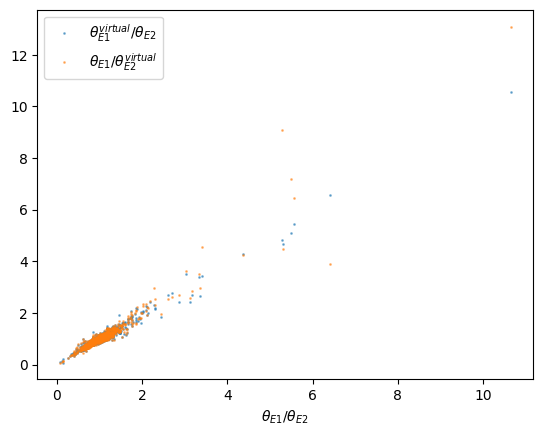

In [5]:
plt.plot(filtered_pairing_parameters["theta_E_ratio"], filtered_pairing_parameters["theta_E1_virtual_by_theta_E2"], "o", markersize=1, alpha=0.5, label=r"$\theta_{E1}^{virtual}/\theta_{E2}$")
plt.plot(filtered_pairing_parameters["theta_E_ratio"], filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"], "o", markersize=1, alpha=0.5, label=r"$\theta_{E1}/\theta_{E2}^{virtual}$")
plt.xlabel(r"$\theta_{E1}/\theta_{E2}$")
plt.legend()

## Likelihood function

$$ \mathcal{L} = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left(-\frac{(x_i - \mu_i))^2}{2\sigma_i^2}\right) $$

where $\theta$ is the parameter of interest, $x_i$ is the observed data, $\mu_i$ is the expected value, and $\sigma_i$ is the standard deviation of the measurement error.

$$x_i = \frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}$$

where $\tilde{\theta}_{E1}$ and $\tilde{\theta}_{E2}$ are measured Einstein radii of the two lenses with deflectors at nearly identical redshifts $z_d$ and sources at $z_1$ and $z_2$.

$$\mu_i = \frac{\theta_{E1}}{\theta_{E2}}\left[\gamma_{pl}, \lambda_{MST}, \beta(z_d, z_1, z_2, \Omega_m, w)\right]$$

where $\gamma_{pl}$ is the power-law slope of the mass profile, $\lambda_{MST}$ is the mass-sheet transformation parameter, and $\beta(z_d, z_1, z_2)$ is the DSPL parameter from distances ratios.

$$\sigma_i^2 = \sigma_{data}^2\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}\right)+ \sigma_{model}^2\left(\frac{{\theta}_{E1}}{{\theta}_{E2}}\right)$$

<!-- $$\sigma_{data}^2\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}\right) = \left|\frac{\Delta\sigma_{v,D}}{\langle \Delta\sigma_{v,D}\rangle}\right|^2 + \left|\frac{\Delta z_{D}}{\langle \Delta z_{D} \rangle}\right|^2 + \left|\frac{\Delta \theta_{D}}{\langle \Delta\theta_{D} \rangle}\right|^2 + \sum_{X = i, r, g, z, y}\left|\frac{\Delta m_{X,D}}{\langle \Delta m_{X,D} \rangle}\right|^2$$ -->

$$\sigma_{data}^2\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}}\right) = \left|\texttt{np.std}\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}} - \frac{\theta_{E1, virtual}}{\theta_{E2}}\right)\right|^2 + \left|\texttt{np.std}\left(\frac{\tilde{\theta}_{E1}}{\tilde{\theta}_{E2}} - \frac{\theta_{E1}}{\theta_{E2, virtual}}\right)\right|^2$$

$$\sigma_{model}^2\left(\frac{{\theta}_{E1}}{{\theta}_{E2}}\right) \simeq \left| \beta \ln \beta \ \delta \gamma_{\text{pl}} \right|^2 
+ (1 - \beta)^2 \left| \delta \lambda_{\text{MST}} \right|^2 
+ \left| \delta \beta \right|^2

In [6]:
sigma_data = (np.std(filtered_pairing_parameters["theta_E_ratio"] - filtered_pairing_parameters["theta_E1_by_theta_E2_virtual"]))**2
sigma_data += (np.std(filtered_pairing_parameters["theta_E_ratio"] - filtered_pairing_parameters["theta_E1_virtual_by_theta_E2"]))**2
sigma_data = np.sqrt(sigma_data)
print("sigma_data", sigma_data)

sigma_data 0.2334652950360551


## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [7]:
# =====================================
# Settings for population of DSP
# =====================================

# number of double source plane lenses
num_dspl = len(filtered_pairing_parameters["theta_E_ratio"])
# num_dspl = 50

# sigma_beta = 0.01  # relative precision on measured Einstein radius ratio
gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.05

# mean values of the parameters
mean_z_D = np.mean(filtered_pairing_parameters["delta_z_D"])
mean_sigma_v_D = np.mean(filtered_pairing_parameters["delta_sigma_v_D"])
mean_size_D = np.mean(filtered_pairing_parameters["delta_size_D"])
mean_mag_i_D = np.mean(filtered_pairing_parameters["delta_mag_i_D"])
mean_mag_r_D = np.mean(filtered_pairing_parameters["delta_mag_r_D"])
mean_mag_g_D = np.mean(filtered_pairing_parameters["delta_mag_g_D"])
mean_mag_z_D = np.mean(filtered_pairing_parameters["delta_mag_z_D"])
mean_mag_y_D = np.mean(filtered_pairing_parameters["delta_mag_y_D"])


def draw_lens(index_pairing):
    """
    draw the likelihood object of a double source plane lens
    """
    # pick a random lens from the filtered pairing parameters
    z_lens = filtered_pairing_parameters["z_D1"][index_pairing] + filtered_pairing_parameters["delta_z_D"][index_pairing]
    z_lens /= 2
    z_source1 = filtered_pairing_parameters["z_S1"][index_pairing]
    z_source2 = filtered_pairing_parameters["z_S2"][index_pairing]

    beta_measured = filtered_pairing_parameters["theta_E_ratio"][index_pairing]

    # sigma for the model
    sigma_sqr_model = 0

    sigma_beta = np.sqrt(sigma_data**2 + sigma_sqr_model)

    kwargs_likelihood = {
        "z_lens": z_lens,
        "z_source": z_source1,
        "z_source2": z_source2,
        "beta_dspl": beta_measured,
        "sigma_beta_dspl": sigma_beta,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood


kwargs_dspl_list = []

for i in range(num_dspl):
    kwargs_dspl_list.append(
        draw_lens(i)
    )

## hierArc sampling settings

In [8]:
## cosmology of the stored lenses

# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo = cosmo_param.cosmo(kwargs_cosmo_true)

In [9]:
# sampling settings
n_walkers = 100
n_run = 200
n_burn = 200

cosmology = "FwCDM"

# TODO: num distribution draws

kwargs_mean_start = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3, "w": -1},
    "kwargs_lens": {
        "lambda_mst": lambda_mst_mean,
        "lambda_mst_sigma": lambda_mst_sigma,
        "gamma_pl_mean": gamma_pl_mean,
        "gamma_pl_sigma": gamma_pl_sigma,
    },
}

kwargs_sigma_start = {
    "kwargs_cosmo": {"h0": 10, "om": 0.05, "w": 0.2},
    "kwargs_lens": {
        "lambda_mst": 0.1,
        "lambda_mst_sigma": 0.01,
        "gamma_pl_mean": 0.1,
        "gamma_pl_sigma": 0.01,
    },
}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w": -2},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w": 0},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},
    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5},
    "kwargs_fixed_lens": {
        "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma,
    },
}


# TODO: add gamma_pl population sampling
# TODO: add lambda_mst_sigma sampling

# joint options for hierArc sampling


kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "GAUSSIAN",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}


kwargs_sampler = {
    "custom_prior": None,
    "interpolate_cosmo": False,
    "num_redshift_interp": 100,
    "cosmo_fixed": None,
}

In [10]:
mcmc_sampler = MCMCSampler(
    kwargs_dspl_list,
    cosmology=cosmology,
    kwargs_model=kwargs_model,
    kwargs_bounds=kwargs_bounds,
    **kwargs_sampler
)

likelihood = mcmc_sampler.chain
param = mcmc_sampler.param

kwargs_test = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3, "w": -1},
    "kwargs_lens": {
        "lambda_mst": lambda_mst_mean,
        "lambda_mst_sigma": lambda_mst_sigma,
        "gamma_pl_mean": gamma_pl_mean + 0.0,
        "gamma_pl_sigma": gamma_pl_sigma,
    },
}

args = param.kwargs2args(**kwargs_test)

%timeit likelihood.likelihood(args)

321 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%load_ext line_profiler

# %lprun -f likelihood.likelihood likelihood.likelihood(args)  # first level

from hierarc.Likelihood.lens_sample_likelihood import LensSampleLikelihood

# %lprun -f LensSampleLikelihood.log_likelihood likelihood.likelihood(args)  # second level


from hierarc.Likelihood.hierarchy_likelihood import LensLikelihood

# %lprun -f LensLikelihood.lens_log_likelihood likelihood.likelihood(args)  # third level

# %lprun -f LensLikelihood.hyper_param_likelihood likelihood.likelihood(args)  # 4th level

%lprun -f LensLikelihood.log_likelihood_single likelihood.likelihood(args)  # 5th level

Timer unit: 1e-09 s

Total time: 0.671091 s
File: /Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/hierarchy_likelihood.py
Function: log_likelihood_single at line 330

Line #      Hits         Time  Per Hit   % Time  Line Contents
   330                                               def log_likelihood_single(
   331                                                   self,
   332                                                   ddt,
   333                                                   dd,
   334                                                   delta_lum_dist,
   335                                                   beta_dsp,
   336                                                   kwargs_lens,
   337                                                   kwargs_kin,
   338                                                   kwargs_source,
   339                 

In [12]:
mcmc_samples, log_prob = mcmc_sampler.mcmc_emcee(
    n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start
)

  0%|          | 2/400 [01:00<3:19:51, 30.13s/it]/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/hierArc/hierarc/Likelihood/hierarchy_likelihood.py:328: RuntimeWarning: divide by zero encountered in log
  return np.log(likelihood / self._num_distribution_draws)
100%|██████████| 400/400 [2:30:39<00:00, 22.60s/it]  


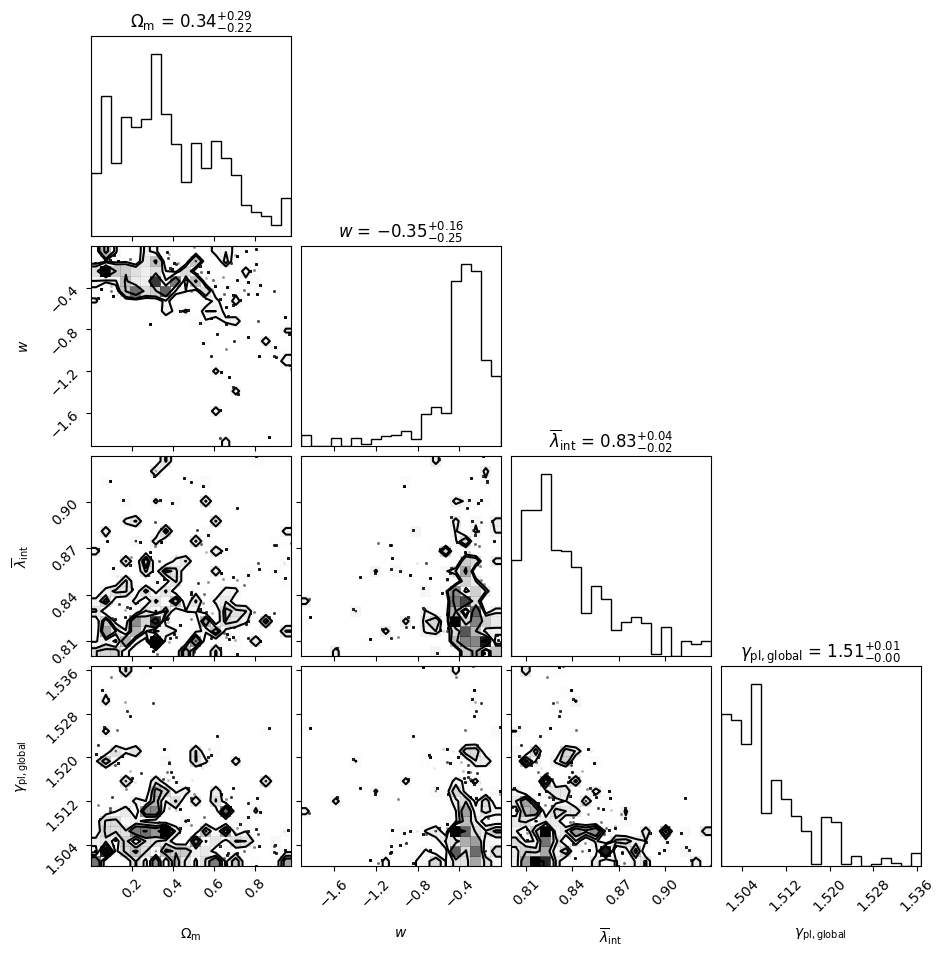

In [14]:
corner.corner(
    mcmc_samples, show_titles=True, labels=mcmc_sampler.param_names(latex_style=True)
)
# plt.savefig("dsp_mst_gamma.pdf", format="pdf", bbox_inches="tight")
plt.show()

For 1000 pairs with filtering, sigma_beta = 0.01*beta_measured

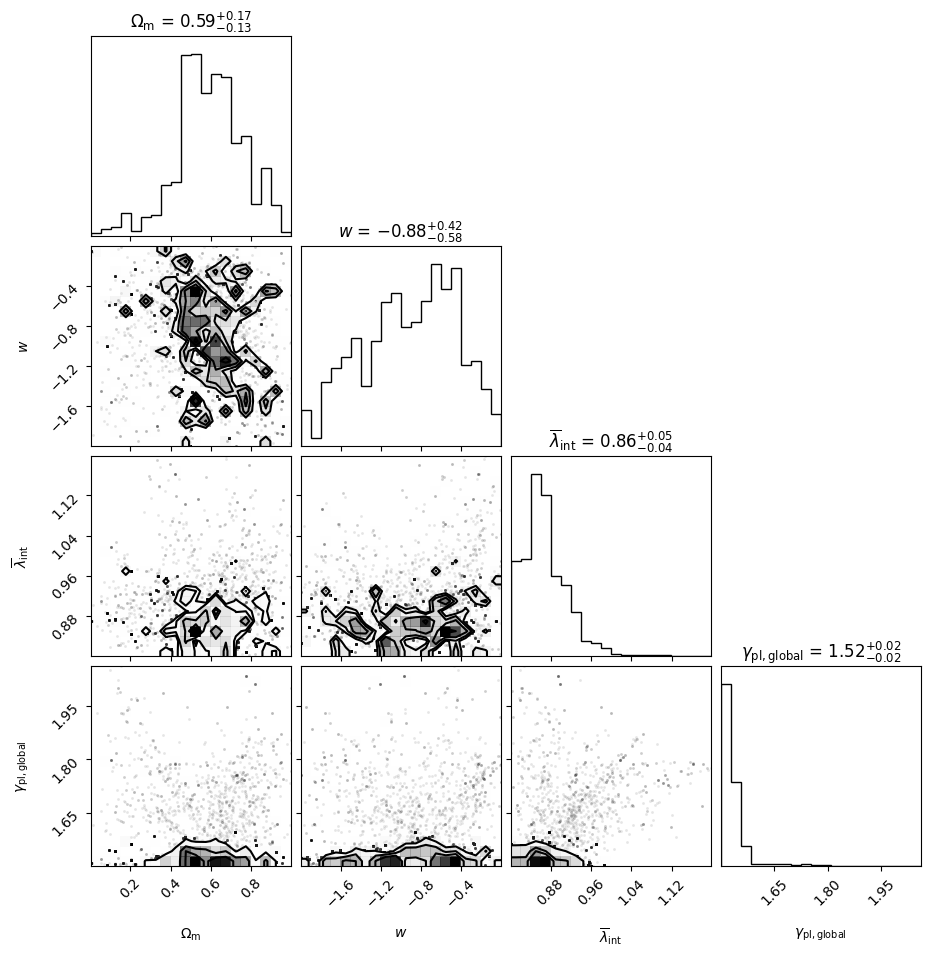

## APPENDIX

### Uncertainity Derivations

#### 1. Uncertainty in the model parameters
$$
\beta_{E,\text{model}} = \beta_E(\gamma_{\text{pl}}, \lambda_{\text{MST}}, \beta(z_d, z_l, z_s, \Omega_m, w))
$$

$$
\delta \beta_{E,\text{model}} = \frac{\partial \beta_E}{\partial \gamma_{\text{pl}}} \delta \gamma_{\text{pl}} 
+ \frac{\partial \beta_E}{\partial \lambda_{\text{MST}}} \delta \lambda_{\text{MST}} 
+ \frac{\partial \beta_E}{\partial \beta} \delta \beta
$$

$$
\beta_E = \left( \beta - (1 - \lambda)(1 - \beta) \right)^{\frac{1}{\gamma_{\text{pl}} - 1}}
$$

$$
\frac{\partial \beta_E}{\partial \beta} = \frac{1}{\gamma_{\text{pl}} - 1}
\left( \beta - (1 - \lambda)(1 - \beta) \right)^{\frac{2 - \gamma_{\text{pl}}}{\gamma_{\text{pl}} - 1}} (2 - \lambda)
$$

$$
\frac{\partial \beta_E}{\partial \lambda} = \frac{1}{\gamma_{\text{pl}} - 1}
\left( \beta - (1 - \lambda)(1 - \beta) \right)^{\frac{2 - \gamma_{\text{pl}}}{\gamma_{\text{pl}} - 1}} (1 - \beta)
$$

$$
\frac{\partial \beta_E}{\partial \gamma_{\text{pl}}} = 
\left( \beta - (1 - \lambda)(1 - \beta) \right)^{\frac{1}{\gamma_{\text{pl}} - 1}} 
\ln\left( \beta - (1 - \lambda)(1 - \beta) \right)
\left( \frac{-1}{(\gamma_{\text{pl}} - 1)^2} \right)
$$

For $\gamma_{\text{pl}} \sim 2$, $\lambda \sim 1$:
$$
\frac{\partial \beta_E}{\partial \beta} \sim 1, \quad
\frac{\partial \beta_E}{\partial \lambda} \sim 1 - \beta, \quad
\frac{\partial \beta_E}{\partial \gamma_{\text{pl}}} \sim -\beta \ln \beta
$$

$$
\sigma^2_{\beta_E,\text{model}} = \left| \frac{\partial \beta_E}{\partial \gamma_{\text{pl}}} \delta \gamma_{\text{pl}} \right|^2
+ \left| \frac{\partial \beta_E}{\partial \lambda_{\text{MST}}} \delta \lambda_{\text{MST}} \right|^2
+ \left| \frac{\partial \beta_E}{\partial \beta} \delta \beta \right|^2
$$

$$
\sigma^2_{\beta_E,\text{model}} \simeq \left| \beta \ln \beta \, \delta \gamma_{\text{pl}} \right|^2 
+ (1 - \beta)^2 \left| \delta \lambda_{\text{MST}} \right|^2 
+ \left| \delta \beta \right|^2
$$

For a power-law mass profile, the Einstein radius is given by (https://ned.ipac.caltech.edu/level5/Sept14/Courteau/Courteau7.html):
$$\theta_E(z_s)
=\Biggl[
  K(\gamma_{pl})\,
  \frac{\sigma_{\rm ap}^2}{c^2}\;
  \frac{D_{\rm ls}(z_{\rm l},\,z_s)}{D_{\rm s}(z_s)}
\Biggr]^{\!1/(\gamma_{pl}-1)}
$$

$$
K(\gamma_{pl})
=\frac{(3-\gamma_{pl})}{2\,\sqrt\pi}\,
\frac{\Gamma\!\bigl(\tfrac{\gamma_{pl}}{2}\bigr)}
     {\Gamma\!\bigl(\tfrac{\gamma_{pl}-1}{2}\bigr)}
$$

and the corresponding beta is 
$$
\beta_{\gamma_{pl}}
=\frac{\theta_E(z_{s2})}{\theta_E(z_{s1})}
=\left[
  \frac{\,D_{\rm ls}(z_{\rm l},\,z_{s2})/D_{\rm s}(z_{s2})\,}
       {\,D_{\rm ls}(z_{\rm l},\,z_{s1})/D_{\rm s}(z_{s1})\,}
\right]^{\!1/(\gamma_{pl}-1)}
$$